In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import emcee
import corner

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

First, let's generate some data.

In [3]:
# Define model parameters
model_a = 0.12
model_b = 1.5
model_c = 0.85
model_sigma = 0.007
model_n = 10

# Define the model
def model(a, b, c, xs):
    return a * np.exp(-xs / b) + c

# Generate data points
model_xs = np.linspace(2., 6., model_n)
model_ys = model(model_a, model_b, model_c, model_xs)

Then we plot the generated data.

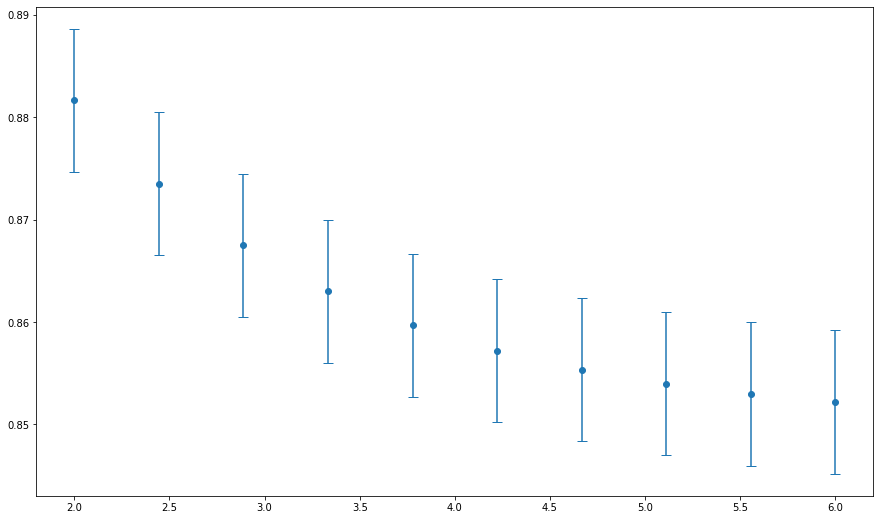

In [4]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Plot the data
ax.errorbar(model_xs, model_ys, yerr=model_sigma, fmt='none', capsize=5)
ax.scatter(model_xs, model_ys)

Now let's define the log likelihood.

In [5]:
def log_likelihood(theta, xs, ys):
    a, b, c = theta
    fit_ys = model(a, b, c, xs)
    return sum(norm.logpdf(fit_ys, ys, model_sigma))

Now we can maximize log likelihood to get a fit to the data.

In [6]:
nll = lambda *args: -log_likelihood(*args)

# Initial values
initial = np.array([0.1, 1., 0.])

# Maximize likelihood
soln = minimize(nll, initial, args=(model_xs, model_ys))
fit_theta = soln.x
soln

      fun: -40.429065967112884
 hess_inv: array([[ 1.17209490e-02, -1.18772783e-01,  7.30865966e-04],
       [-1.18772783e-01,  1.29073337e+00, -8.77292086e-03],
       [ 7.30865966e-04, -8.77292086e-03,  7.18690413e-05]])
      jac: array([-5.48362732e-05, -7.15255737e-06, -2.34127045e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 400
      nit: 33
     njev: 97
   status: 2
  success: False
        x: array([0.11999858, 1.50001617, 0.84999987])

Let's plot this.

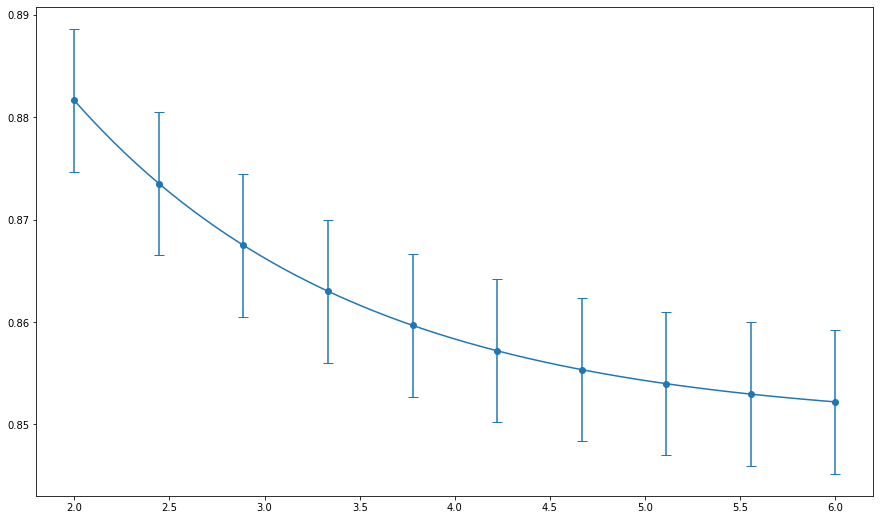

In [7]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Plot the data
ax.errorbar(model_xs, model_ys, yerr=model_sigma, fmt='none', capsize=5)
ax.scatter(model_xs, model_ys)

# Plot the fit
fit_a, fit_b, fit_c = fit_theta
fit_xs = np.linspace(2., 6., 201)
fit_ys = model(fit_a, fit_b, fit_c, fit_xs)
ax.plot(fit_xs, fit_ys)

Now let's try MCMC. First we set up the log prior and log posterior.

In [8]:
def log_prior(theta):
    a, b, c = theta
    if a > 0. and b > 0.:
        return -np.log(a) - np.log(b)
    else:
        return -np.inf

def log_posterior(theta, xs, ys):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    ll = log_likelihood(theta, xs, ys)
    if not np.isfinite(ll):
        return -np.inf
    
    return lp + ll

Now we set up the optimization parameters.

In [9]:
ndim     = len(fit_theta)  # number of parameters in the model
nwalkers = 2 * ndim        # number of MCMC walkers
nburn    = 500             # "burn-in" period to let chains stabilize
nthin    = 50              # thin by about half the autocorrelation time
nsteps   = 5000            # number of MCMC steps to take

Then we can sample the distribution.

In [10]:
# Iniitalize the walkers
np.random.seed(42)
starting_guesses = fit_theta + ([1e-4] * ndim) * np.random.randn(nwalkers, ndim)

# Run sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(model_xs, model_ys))
sampler.run_mcmc(starting_guesses, nsteps, progress=True)

# Display autocorrelation time
sampler.get_autocorr_time(quiet=True)

# Save samples
flat_samples = sampler.get_chain(discard=nburn, thin=nthin, flat=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 323.19it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [241.27828088 294.24176797 247.95906884]


The autocorrelation times are shockingly long. If we increase the number of steps, the autocorrelation times increase as well, so it seems like the model is unstable somehow.

Let's see what the corner plot look like.

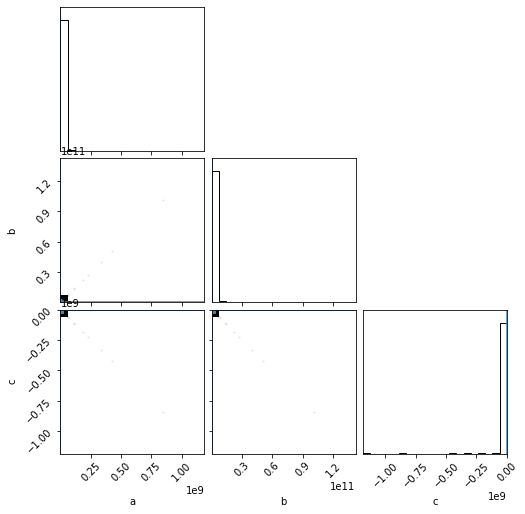

In [11]:
fig = corner.corner(
    flat_samples, labels=['a', 'b', 'c'], truths=fit_theta
)

And if we plot the 50th percentile fit:

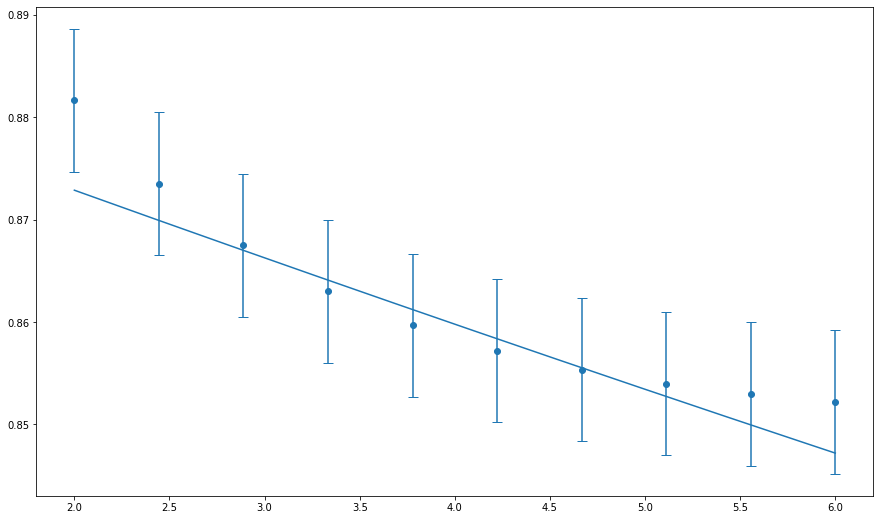

In [12]:
# Get 50th percentile model parameters
mcmc_theta = np.percentile(flat_samples, [50], axis=0)[0]

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Plot the data
ax.errorbar(model_xs, model_ys, yerr=model_sigma, fmt='none', capsize=5)
ax.scatter(model_xs, model_ys)

# Plot the fit
mcmc_a, mcmc_b, mcmc_c = mcmc_theta
mcmc_xs = np.linspace(2., 6., 201)
mcmc_ys = model(mcmc_a, mcmc_b, mcmc_c, mcmc_xs)
ax.plot(mcmc_xs, mcmc_ys)

The fit line is way off.